# Leyendo archivos XML

En este script hacemos una pequeña introducción al uso de BeautifulSoup para extraer datos de una página XML.

## Acerca de este ejemplo

Una forma común de transmitir datos por Internet es el uso del formato XML.

En este ejemplo les muestro datos de tipos de cambio del peso chileno, el euro, y la libra esterlina, del 5 de enero de 2015 al 30 de enero de 2021. Los datos fueron descargados del sitio web del FMI.

En el archivo XML se presenta una observación a la vez. Por ejemplo, la primera observación está representada así:

    <EFFECTIVE_DATE VALUE="05-Jan-2015">
       <RATE_VALUE CURRENCY_CODE="Chilean peso" ISO_CHAR_CODE="CLP">
          612.47
       </RATE_VALUE>
       <RATE_VALUE CURRENCY_CODE="Euro" ISO_CHAR_CODE="EUR">
          1.1915
       </RATE_VALUE>
       <RATE_VALUE CURRENCY_CODE="U.K. pound" ISO_CHAR_CODE="GBP">
          1.5254
       </RATE_VALUE>
     </EFFECTIVE_DATE>

Nuestra tarea consiste en extraer los datos de cada observación, y concatenarlos en una tabla de pandas.

In [1]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup

Archivo de datos

In [2]:
GITHUB_REPO = "https://raw.githubusercontent.com/randall-romero/econometria/master/data/"
DATAPATH = GITHUB_REPO if 'google.colab' in str(get_ipython()) else '../../data/'

filename = 'Exchange_Rate_Report.xml'

Esta función nos ayudará a convertir los datos a pandas

In [3]:
def soup_to_pandas(dato_como_soup):
    """
    Convierte una observación del archivo XML a una tabla de una observación en pandas.

    Por ejemplo, la observación descrita arriba se convierte a:

                       CLP     EUR     GBP
        05-Jan-2015  612.47  1.1915  1.5254

    """

    datodict = {dato['ISO_CHAR_CODE'] : dato.getText() for dato in dato_como_soup.findAll('RATE_VALUE')}

    return pd.DataFrame(datodict, index=[dato_como_soup['VALUE']])

Listos para procesar el archivo

In [4]:
with open(DATAPATH + filename, mode='r') as page:
    soup = BeautifulSoup(page, 'xml', from_encoding='utf-8')
    obs_strings = soup.findAll('EFFECTIVE_DATE')
    datos = pd.concat([soup_to_pandas(s) for s in obs_strings])

Convertimos los datos a float (numéricos)

In [5]:
datos = datos.replace('N/A',np.nan).astype(float)

Convertimos el índice a fechas (períodos)

In [6]:
datos.index = pd.to_datetime(datos.index)
datos.index = datos.index.to_period('D')
datos = datos.reindex(pd.period_range(datos.index[0], datos.index[-1],freq='d'))

Rellenamos datos del fin de semana

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

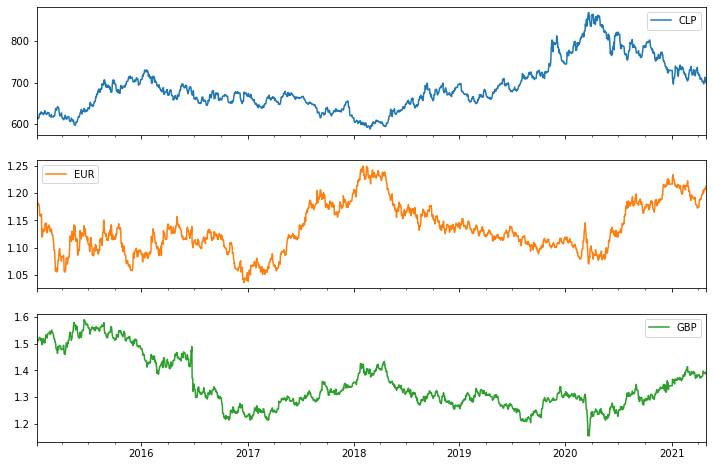

In [7]:
datos.fillna(method='ffill', inplace=True)
datos.plot(subplots=True, figsize=[12,8])